# Dataset Downloading & Exploring

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("feyzazkefe/trashnet")

print("Path to dataset files:", path)

c:\Users\Isisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Isisa\.cache\kagglehub\datasets\feyzazkefe\trashnet\versions\1


In [3]:
import os

dataset_path = os.path.join(path, 'dataset-resized')
classes = os.listdir(dataset_path)
print("Classes:", classes)

for c in classes:
    print(c, "->", len(os.listdir(os.path.join(dataset_path, c))), "images")


Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
cardboard -> 403 images
glass -> 501 images
metal -> 410 images
paper -> 594 images
plastic -> 482 images
trash -> 137 images


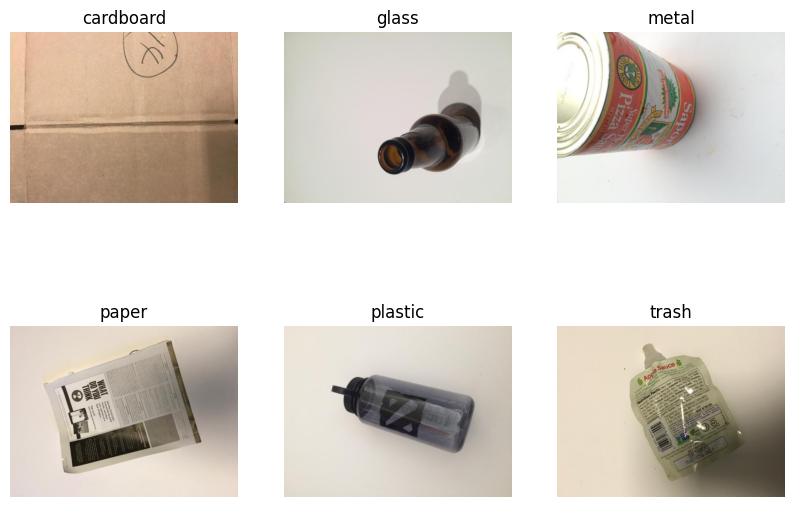

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

# seeing a sample from data
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for ax, c in zip(axes.ravel(), classes):
    img_path = os.path.join(dataset_path, c, os.listdir(os.path.join(dataset_path, c))[0])
    ax.imshow(Image.open(img_path))
    ax.set_title(c)
    ax.axis("off")

plt.show()


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image

# Preprocessing & Augmenting images  Then Splitting into train and test

In [6]:
# Create ImageDataGenerator with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    validation_split=0.2,  # 20% validation split
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    horizontal_flip=True,  # Random horizontal flip
    brightness_range=[0.8,1.2],  # Random brightness
    fill_mode='nearest'
)

# Validation generator without augmentations, only normalization
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Set image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create train generator
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Create validation generator
validation_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", validation_generator.samples)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Number of training samples: 2024
Number of validation samples: 503


# class weights to handle imbalance

In [7]:
import numpy as np
from sklearn.utils import class_weight

# labels for training data
labels = train_generator.classes

# compute balanced weights automatically
weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.04437564499484), 1: np.float64(0.8412302576891105), 2: np.float64(1.0284552845528456), 3: np.float64(0.7086834733893558), 4: np.float64(0.8739205526770294), 5: np.float64(3.066666666666667)}


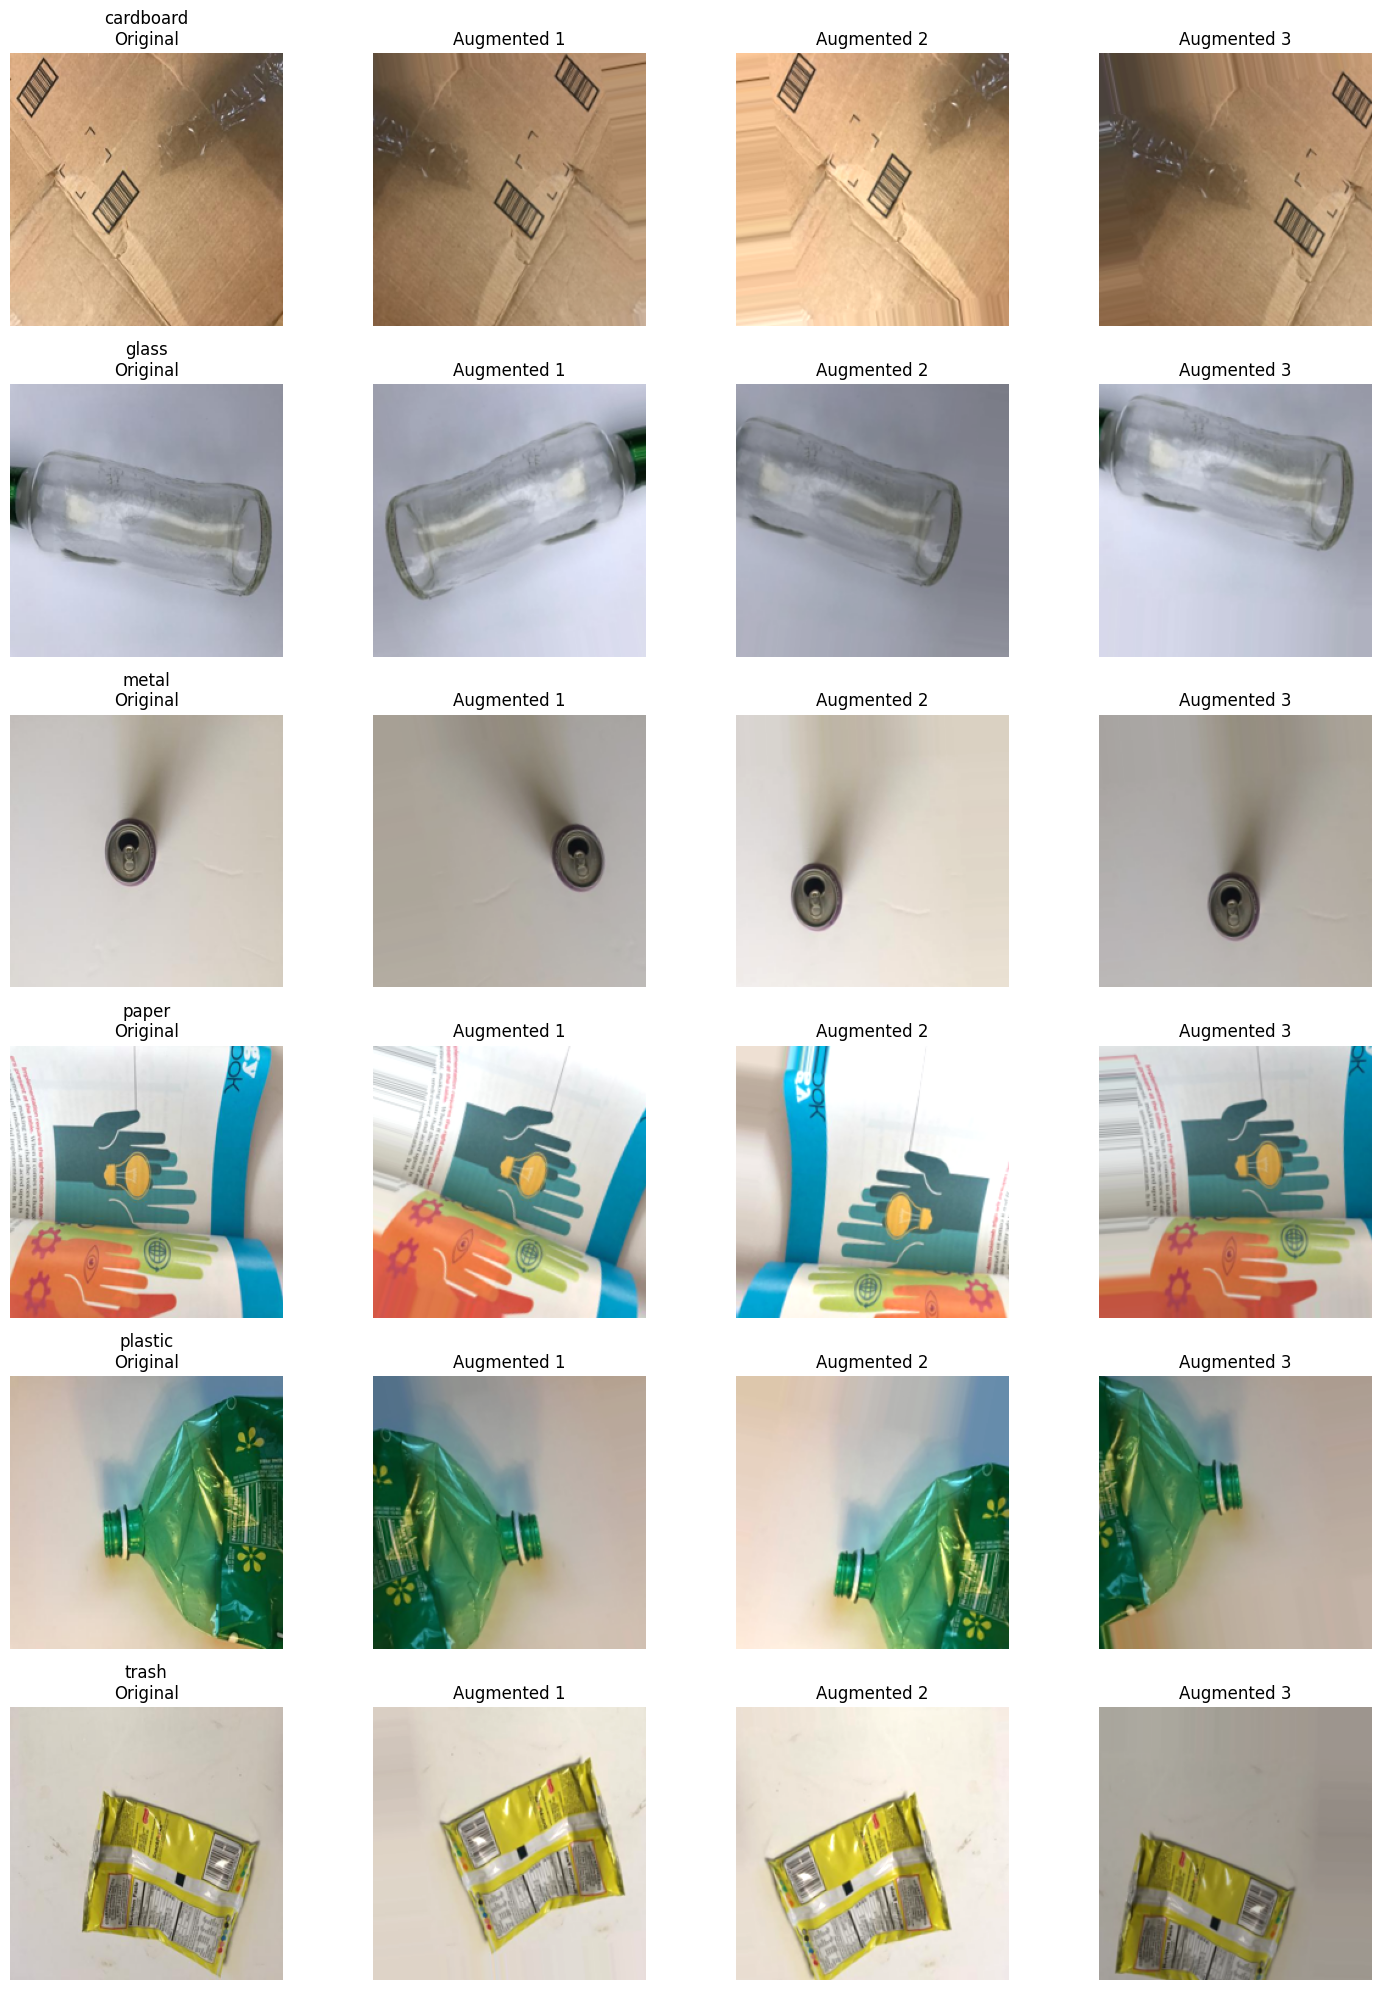

In [8]:
def show_augmented_samples():
    plt.figure(figsize=(15, 20))
    
    for class_idx, class_name in enumerate(classes):
        # Get random images from class
        class_path = os.path.join(dataset_path, class_name)
        img_files = os.listdir(class_path)
        sample_file = np.random.choice(img_files)
        
        # Load and preprocess image
        img_path = os.path.join(class_path, sample_file)
        original_img = Image.open(img_path).resize(IMG_SIZE)
        # Keep original image dimensions for better visualization
        img_array = np.array(original_img)
        
        # Plot original
        plt.subplot(len(classes), 4, class_idx*4 + 1)
        plt.imshow(img_array)  # Normalize for display
        plt.title(f"{class_name}\nOriginal")
        plt.axis('off')
        
        # Reshape image for generator
        img_array = img_array.reshape((1,) + img_array.shape)
        
        # Generate 3 augmented versions
        aug_iter = train_datagen.flow(img_array, batch_size=1)
        for i in range(3):
            augmented = next(aug_iter)[0]
            plt.subplot(len(classes), 4, class_idx*4 + i + 2)
            plt.imshow(augmented)
            plt.title(f"Augmented {i+1}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show augmented samples
show_augmented_samples()

In [9]:
import pickle

# Save class names
with open(os.path.join("process_data","classes.pkl"), "wb") as f:
    pickle.dump(classes, f)

# Save class weights
with open(os.path.join("process_data","class_weights.pkl"), "wb") as f:
    pickle.dump(class_weights, f)

# Save dataset path and image size (optional)
metadata = {
    "dataset_path": dataset_path,
    "IMG_SIZE": IMG_SIZE,
    "BATCH_SIZE": BATCH_SIZE
}
with open(os.path.join("process_data","metadata.pkl"), "wb") as f:
    pickle.dump(metadata, f)
    